# Основная информация проекта

## Цель проекта
Написать скоринговую модель предсказания дефолта клиентов банка.

## Описание датасета
1. **client_id** - идентификатор клиента;
2. **education** - уровень образования;
3. **sex** - пол заёмщика;
4. **age** - возраст заёмщика;
5. **car** - флаг наличия автомобиля;
6. **car_type** - флаг автомобиля-иномарки;
7. **decline_app_cnt** - количество отказанных прошлых заявок;
8. **good_work** - флаг наличия «хорошей» работы;
9. **bki_request_cnt** - количество запросов в БКИ;
10. **home_address** - категоризатор домашнего адреса;
11. **work_address** - категоризатор рабочего адреса;
12. **income** - доход заёмщика;
13. **foreign_passport** - наличие загранпаспорта;
14. **sna** - связь заемщика с клиентами банка;
15. **first_time** - давность наличия информации о заемщике;
16. **score_bki** - скоринговый балл по данным из БКИ;
17. **region_rating** - рейтинг региона;
18. **app_date** - дата подачи заявки;
19. **default** - наличие дефолта.


**Целевая переменная** - "default"

## Задачи проекта
 1. Провести первичную обработку данных. Написать вспомогательные функции;
 2. Обнаружить и устранить выбросы для числовых переменных;
 3. Составить отчёт по результатам анализа данных.
 
## Этапы выполнения проекта
 1. **[Импорт библиотек и загрузка данных](#Импорт-библиотек-и-загрузка-данных)**
 2. **[Написание функций для обработки и анализа данных](#Функции-для-обработки-и-анализа-данных)**
 3. **[Обзор данных](#Обзор-данных)**

# Импорт библиотек и загрузка данных

In [1]:
import warnings
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, auc, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif, mutual_info_classif

import numpy as np
import pandas as pd
import pandas_profiling
import random

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

warnings.simplefilter('ignore')

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [3]:
df_train['sample'] = 1
df_test['sample'] = 0
df_test['default'] = 0

df = df_train.append(df_test, sort=False).reset_index(drop=True)

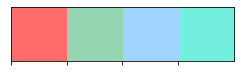

In [4]:
custom_colors = ["#ff6b6b", "#95d5b2", "#a2d2ff", "#72efdd"]
sns.palplot(sns.color_palette(custom_colors))

# Функции для обработки и анализа данных

In [5]:
def fill_na_values(column, data):
    '''Функция для заполнения пустых значений в зависимости от типа данных в столбце. 
    Если данные числовые, то пропуск будет заполнен медианой, 
    а остальные будут заполнены рандомно с учетом вероятности.
    '''
    if data.loc[:, column].dtypes == np.dtype('O'):
        values = data[column].value_counts()
        index = data[data[column].isna() == True].index
        new_value = pd.Series(random.choices(
            values.index, values, k=data[column].isna().sum()))
        new_value.index = index
        return data[column].fillna(new_value)
    else:
        return data[column].fillna(data[column].median())

In [6]:
def parsing_all_columns_data(data):
    '''Функция для анализа всех столбцов на количество 
    уникальных значений и количество пропусков'''
    
    for col in data.columns:
        unique_values = len(data[col].value_counts())
        empty_values = data[col].isna().sum()
        print(
            f"В столбце '{col}' уникальных значений = {unique_values} ,а количество пропусков = {empty_values}.")
        print(
            f'Процент пропусков = {round(empty_values*100/data.shape[0],1)}%')        

In [7]:
def definition_duplicates(data):
    '''Функция для определия дубликатов в датасете
    '''

    duplicate_data = data.duplicated().sum()
    if duplicate_data > 0:
        print('В датасете присутствуют дубликаты')
    else:
        print('В датасете дубликаты отсутствуют')

In [8]:
def display_iqr(column, data):
    '''Функция построения графиков для каждого столбца с определением границ для их данных.
    '''

    if data.loc[:, column].dtypes != np.dtype('O'):
        IQR = data[column].quantile(
            0.75) - data[column].quantile(0.25)
        perc25 = data[column].quantile(0.25)
        perc75 = data[column].quantile(0.75)
        # Определим границы
        min_value, max_value = define_boundaries(data,column)
        data_out = data.loc[(~data.loc[:, column].between(
            min_value, max_value)) & (pd.notnull(data.loc[:, column]))]
        # Выведем полученные данные
        print_IQR(column, IQR, perc25, perc75,
                  min_value, max_value, data_out)

        data[column].loc[data[column].between(min_value, max_value)].hist(
            bins=10, range=(min_value, max_value), label='IQR')

        plt.legend()
        plt.show()

        display_data_out(data_out, column)

In [9]:
def define_boundaries(data,column):
    '''Функция определия границ выбросов 
    для определённой колонки(column) датасета
    '''

    IQR = data[column].quantile(
        0.75) - data[column].quantile(0.25)
    perc25 = data[column].quantile(0.25)
    perc75 = data[column].quantile(0.75)
    min_value = perc25 - 1.5*IQR
    max_value = perc75 + 1.5*IQR

    return min_value, max_value

In [10]:
def display_data_out(data, column):
    '''Функция для отображения найденных выбросов
    '''

    if 0 < len(data) >= 5:
        print(f'Отображение первых 5 строк с ошибками в столбце {column}')
        display(data.head(5))
    elif len(data) == 1:
        print(f'Отображение строки с ошибкой в столбце {column}')
        display(data)

In [11]:
def print_IQR(column, IQR, perc25, perc75, min_value, max_value, data_out):
    '''Функция вывода данных'''

    print(f'Распределение IQR для столбца - {column}')
    print(f'Количество ошибок - {data_out.shape[0]}')
    print('25-й перцентиль: {},'.format(perc25),
          '75-й перцентиль: {},'.format(perc75),
          'IQR: {}, '.format(IQR),
          'Границы выбросов: [{}, {}].'.format(min_value, max_value))

In [12]:
def cols_to_drop(data):
    '''Функция для определия столбцов, 
    не влияющих на целевую переменную'''

    # Поиск колонок с большим количеством пропусков, более 90%
    many_null_cols = [
        col for col in data.columns if data[col].isnull().sum() / data.shape[0] > 0.9]
    # Поиск колонок в которых одно из значений встречается > 95%
    big_top_value_cols = [col for col in data.columns if data[col].value_counts(
        dropna=False, normalize=True).values[0] > 0.95]
    # Поиск колонок в которых только одно значение
    one_value_cols = [col for col in data.columns if data[col].nunique() <= 1]

    return list(set(many_null_cols + big_top_value_cols + one_value_cols))

# Обзор данных

In [13]:
# Проверка на успешность загрузки данных и краткий вывод таблицы с информацией
display(df.head())
df.info()

client_id   app_date education sex  age car car_type  decline_app_cnt  \
0      25905  01FEB2014       SCH   M   62   Y        Y                0   
1      63161  12MAR2014       SCH   F   59   N        N                0   
2      25887  01FEB2014       SCH   M   25   Y        N                2   
3      16222  23JAN2014       SCH   F   53   N        N                0   
4     101655  18APR2014       GRD   M   48   N        N                0   

   good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0          0  -2.008753                1             50             1   
1          0  -1.532276                3             50             2   
2          0  -1.408142                1             80             1   
3          0  -2.057471                2             50             2   
4          1  -1.244723                1             60             2   

   work_address  income  sna  first_time foreign_passport  default  sample  
0             2   18000    4           1                N        0       1  
1             3   19000    4           1                N        0       1  
2             2   30000    1           4                Y        0       1  
3             3   10000    1           3                N        0       1  
4             3   30000    1           4                Y        0       1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [14]:
# Вывод количества строк и столбцов таблицы
print(
    f'Датасет состоит из {df.shape[0]} строк и {df.shape[1]} столбцов')

Датасет состоит из 110148 строк и 20 столбцов


In [15]:
# Подсчёт уникальных значений и количество пропусков в столбцак датасета
parsing_all_columns_data(df)

В столбце 'client_id' уникальных значений = 110148 ,а количество пропусков = 0.
Процент пропусков = 0.0%
В столбце 'app_date' уникальных значений = 120 ,а количество пропусков = 0.
Процент пропусков = 0.0%
В столбце 'education' уникальных значений = 5 ,а количество пропусков = 478.
Процент пропусков = 0.4%
В столбце 'sex' уникальных значений = 2 ,а количество пропусков = 0.
Процент пропусков = 0.0%
В столбце 'age' уникальных значений = 52 ,а количество пропусков = 0.
Процент пропусков = 0.0%
В столбце 'car' уникальных значений = 2 ,а количество пропусков = 0.
Процент пропусков = 0.0%
В столбце 'car_type' уникальных значений = 2 ,а количество пропусков = 0.
Процент пропусков = 0.0%
В столбце 'decline_app_cnt' уникальных значений = 24 ,а количество пропусков = 0.
Процент пропусков = 0.0%
В столбце 'good_work' уникальных значений = 2 ,а количество пропусков = 0.
Процент пропусков = 0.0%
В столбце 'score_bki' уникальных значений = 102618 ,а количество пропусков = 0.
Процент пропусков = 0.0

In [16]:
definition_duplicates(df)

В датасете дубликаты отсутствуют


In [17]:
# бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']

# категориальные переменные
cat_cols = ['education', 'region_rating',
            'work_address', 'home_address''sna', 'first_time']

# числовые переменные
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki']

In [18]:
pandas_profiling.ProfileReport(df)

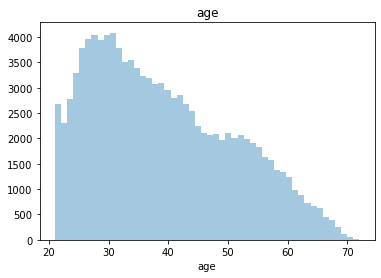

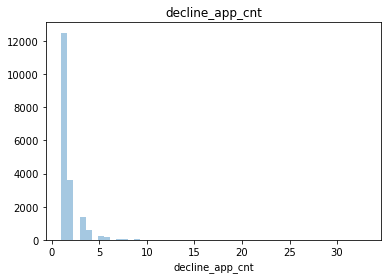

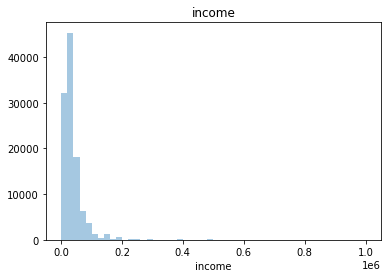

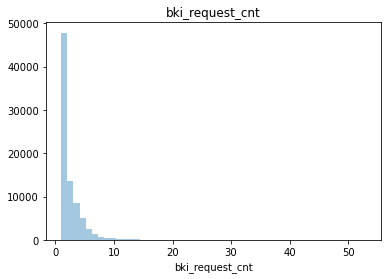

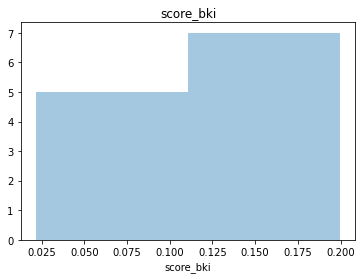

In [19]:
for col in num_cols:
    plt.figure()
    sns.distplot(df[col], kde=False,rug=False)
    plt.title(col)
    plt.show()

In [20]:
for column in num_cols:
    df[column] = np.log(df[column])

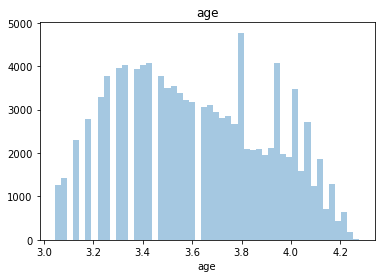

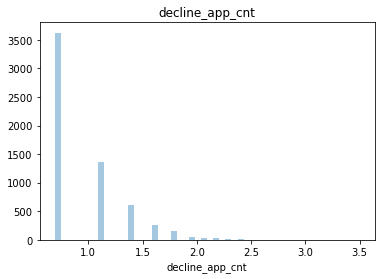

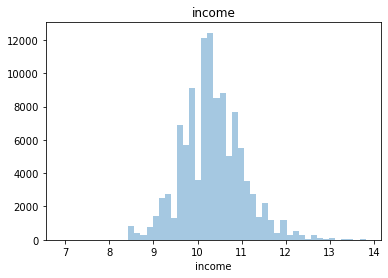

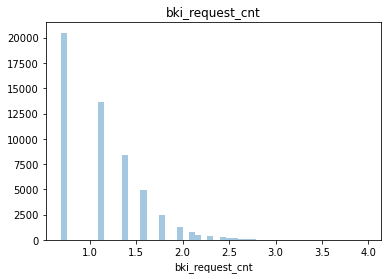

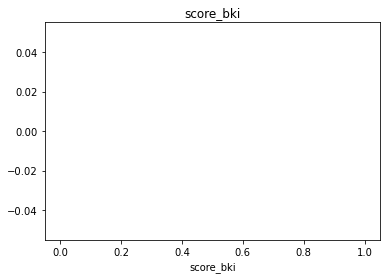

In [21]:
for col in num_cols:
    plt.figure()
    sns.distplot(df[col][df[col] >0].dropna(), kde=False,rug=False)
    plt.title(col)
    plt.show()

In [22]:
#for column in num_cols:
#    df[column] = df[column][df[column] >0]

In [23]:
#for column in num_cols:
#    display_iqr(column, df)

In [24]:
cols_to_drop(df)

['score_bki']

In [25]:
df['education'] = fill_na_values('education',df)

In [26]:
label_encoder = LabelEncoder()

In [27]:
for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
df['education'] = label_encoder.fit_transform(df['education'])  

df = df.drop('app_date',axis=1)

df.head()

client_id  education  sex       age  car  car_type  decline_app_cnt  \
0      25905          3    1  4.127134    1         1             -inf   
1      63161          3    0  4.077537    0         0             -inf   
2      25887          3    1  3.218876    1         0         0.693147   
3      16222          3    0  3.970292    0         0             -inf   
4     101655          1    1  3.871201    0         0             -inf   

   good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0          0        NaN         0.000000             50             1   
1          0        NaN         1.098612             50             2   
2          0        NaN         0.000000             80             1   
3          0        NaN         0.693147             50             2   
4          1        NaN         0.000000             60             2   

   work_address     income  sna  first_time  foreign_passport  default  sample  
0             2   9.798127    4           1                 0        0       1  
1             3   9.852194    4           1                 0        0       1  
2             2  10.308953    1           4                 1        0       1  
3             3   9.210340    1           3                 0        0       1  
4             3  10.308953    1           4                 1        0       1

In [28]:
df_train = df.query('sample == 1').drop(['sample'], axis=1)
df_test = df.query('sample == 0').drop(['sample'], axis=1)

# Extract data and label
X = df_train.drop(['default'], axis=1)
y = df_train[['default']]

# Extract data for validation
X_valid = df_test.drop(['default'], axis=1)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=False, random_state=42)

In [30]:
model = LogisticRegression()

In [31]:
#model.fit(X_train,y_train)

In [32]:
fpr, tpr, threshold = roc_curve(y_test,model.predict_proba(X_test)[:,1])
roc_auc = roc_auc_score(y_test,model.predict_proba(X_test)[:,1])

plt.figure(figsize=(14,8))
plt.plot([0,1],label='Baseline',linestyle='--')
plt.plot(fpr,tpr,label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.